# Boundary Tree

####This notebook is an implementation of Boundary Forest Algorithm([Paper](https://arxiv.org/pdf/1505.02867.pdf)) 
#### Above paper was published at Proc. of the 29th AAAI Conference on Artificial Intelligence (AAAI) by Disney Research

Online	algorithm	that	performs	effectively	and	efficiently	
• Accuracy:	~kNN
• Time:	O(logN),	both	train	&	query	
• Memory:	O(N)	

The speed of this algorithm makes it appropriate for applications
such as real-time machine learning, and metric
learning.

In [1]:
import uuid
import math
import numpy as np

class bf_Node(object):
    def __init__(self, label=None, data=(None,None), k=3):
        """
            k - number of childern
            label - usual is the label in clustering task
            data - vector
        """
        self.data = tuple(data)
        self.children = []
        self.nChildren = k
        self.label = label

    def axis_dist(self, point, axis):
        """
        Squared distance at the given axis between
        the current Node and the given point
        """
        return math.pow(self.data[axis] - point[axis], 2)


    def dist(self, point, is_bf_node=True):
        """
        Squared distance between the current Node
        and the given point
        """
        if is_bf_node:
            vector = point.data
        else:
            vector = tuple(point)
        r = range(len(vector))
        return sum([self.axis_dist(vector, i) for i in r])
    
    def level(self):
        if self.is_leaf:
            return 1
        else:
            num_lvls = [i.level() for i in self.children]
            return max(num_lvls) + 1
    
    def to_ascii(self):
        if self.is_leaf:
            return "N:"+str(self.label)
        else:
            num_lvls = tuple(i.to_ascii() for i in self.children)
            return "("+",".join(num_lvls)+")" + "N:"+str(self.label)

    @property
    def is_leaf(self):
        return True if len(self.children)==0 else False
    
    def add_leaf(self, node):
        if self.is_leaf:
            if self.label != node.label:
                self.children.append(node)
        else:            
            kdist = [i.dist(node) for i in self.children]
            selfdist = self.dist(node)
            argmin = np.argmin(kdist)
            if selfdist < kdist[argmin] and self.label != node.label and len(self.children) < self.nChildren:
                self.children.append(node)
            else:
                self.children[argmin].add_leaf(node)

    def visualize_graph(self, tree=None):
        name = uuid.uuid4().hex
        if tree==None:
            from graphviz import Digraph
            tree = Digraph()
        tree.node(name, str(self.data)+","+str(self.label))

        if self.is_leaf:
            return name, tree
        else:
            for i in self.children:
                tree.edge(name,i.visualize_graph(tree)[0])
            return name, tree
    
    
    def query(self, query_node):
        if self.is_leaf:
            return self.label
        else:
            kdist = [i.dist(query_node, False) for i in self.children]
            selfdist = self.dist(query_node, False)
            argmin = np.argmin(kdist)
            if selfdist < kdist[argmin] and len(self.children) < self.nChildren:
                return self.label
            else:
                return self.children[argmin].query(query_node)

class bf_tree(bf_Node):
    def __init__(self, k=3, *args, **kwargs):
        super(bf_tree, self).__init__(*args, **kwargs)

        self.nChildren = k
        self.tree = None

    def add(self, X, y):
        self.label = y[0]
        self.data = X[0]
        for i in range(1,len(X)):
            node = bf_Node(y[i],X[i],self.nChildren)
            self.add_leaf(node)
    
    def visualize(self):
        vis = self.visualize_graph()[1]
        return vis


## Generating Data
Consider the following two-dimensional data, which has one of four class labels:


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


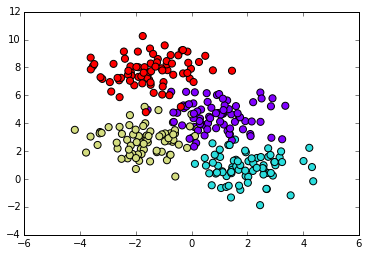

In [2]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline  

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [4]:

def visualize_classifier(tree, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    tree.add(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    
    t = np.c_[xx.ravel(), yy.ravel()]
    Z=[]
    for i in t: 
        Z.append(tree.query(i))
    
    Z = np.array(Z).reshape(xx.shape)
    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)


## Visualizing Results
Now we can examine what the decision tree classification looks like:


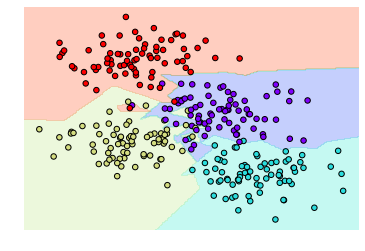

In [6]:
tree = bf_tree()
tree.add(X,y)
visualize_classifier(tree, X, y)

### You can also visualize the tree structure like below

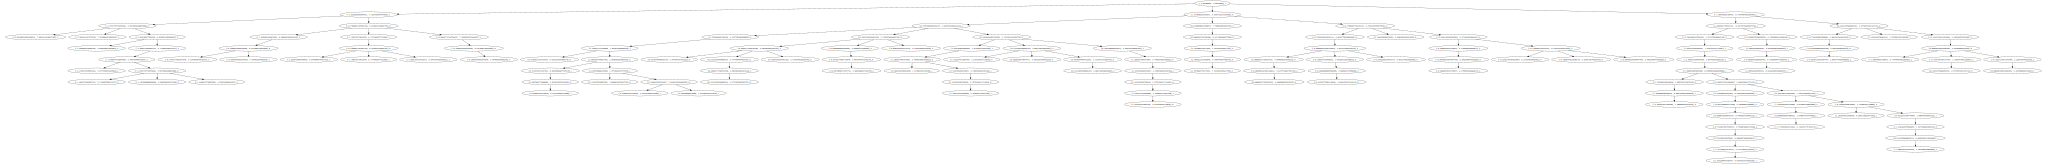

In [7]:
tree.visualize()